In [76]:
import numpy as np
import scipy as sc
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors

<h1>Invertierter Verstärker<h1>

Verstärkung

modified transition index 0:
18
Leerlaufverstärkung:
Mittelwert: 174.64
Unsicherheit des Mittelwerts: 2.611
f_cutoff = 31700.0 $pm$ 700.0
modified transition index 1:
22
Leerlaufverstärkung:
Mittelwert: 123.26
Unsicherheit des Mittelwerts: 1.285
f_cutoff = 64700.0 $pm$ 300.0
modified transition index 2:
24
Leerlaufverstärkung:
Mittelwert: 84.70
Unsicherheit des Mittelwerts: 1.044
f_cutoff = 82600.0 $pm$ 1400.0


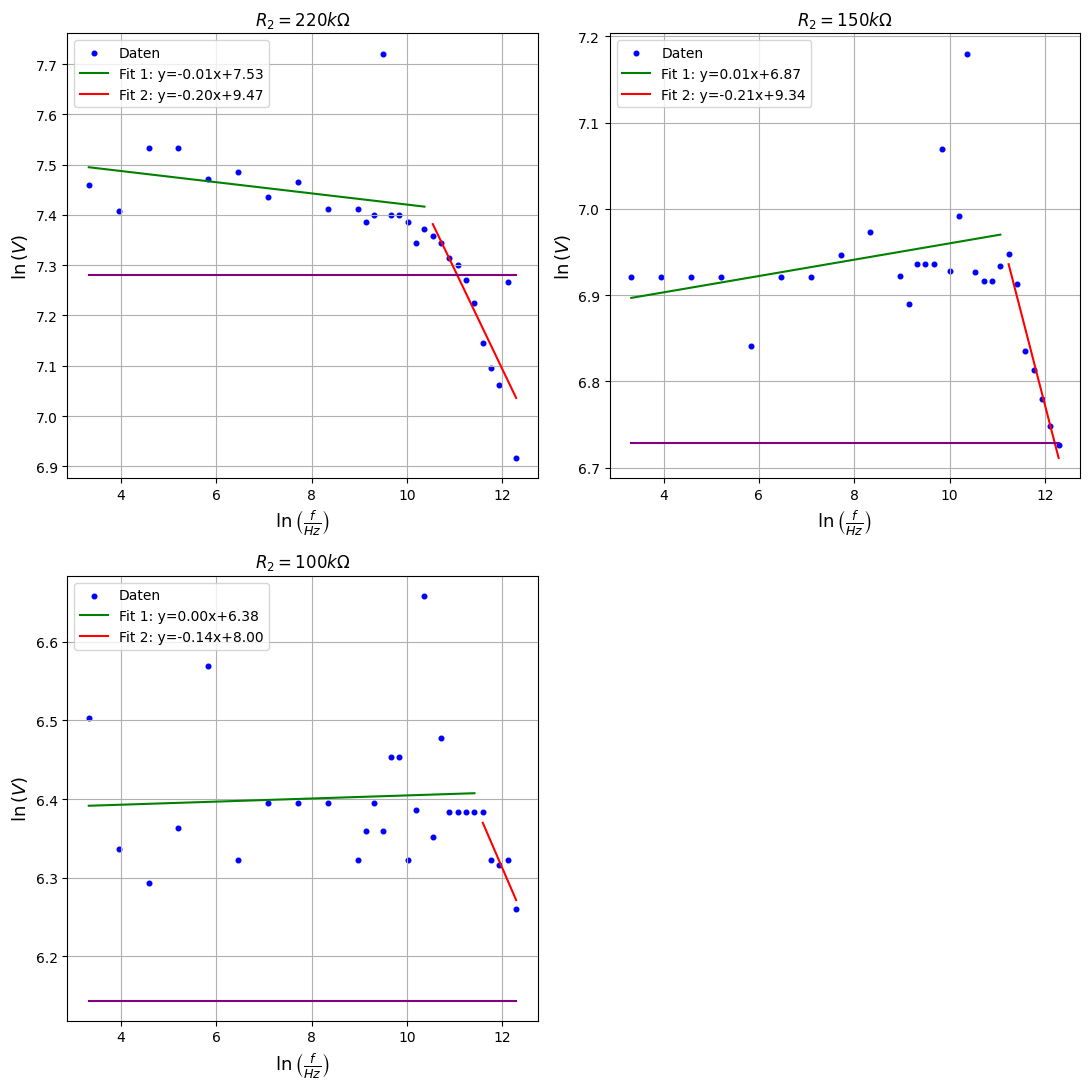

In [257]:
def linear_fit(x, a, b):

    return a * x + b



# Load the data files into dataframes

file_paths = {

    "Invert_220k": "../data/Invert_220k.txt",

    "Invert_150k": "../data/Invert_150k.txt",

    "Invert_100k": "../data/Invert_100k.txt"

}

dataframes = {}

for key, path in file_paths.items():

    # Read the file, split by semicolon, and skip the header

    data = pd.read_csv(path, delimiter=';', skiprows=1, names=['Frequency_Hz', 'Amplified_V', 'Unamplified_mV', 'Phase_Deg'])

    # Remove any extra whitespace from column names and values

    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    dataframes[key] = data

# Liste zum Speichern der Figure-Objekte
figures = []

def toplabel(key):
    if key == "Invert_220k":
        return r"$R_2 = 220k\Omega$"
    if key == "Invert_150k":
        return r"$R_2 = 150k\Omega$"
    if key == "Invert_100k":
        return r"$R_2 = 100k\Omega$"

def modify_cutoff_point(transition_index,i):
    if i == 0:
        transition_index += 6
    if i == 1:
        transition_index += 8
    if i == 2:
        transition_index += 10

    return transition_index

def get_amp(i):
    if i == 0:
        return 220
    if i == 1:
        return 150
    if i == 2:
        return 100
    
def intersect_error( popt1, popt2, errors1, errors2 ):
    a1 = popt1[0]
    a2 = popt2[0]
    b1 = popt1[1]
    b2 = popt2[1]

    da1 = errors1[0]
    da2 = errors2[0]
    db1 = errors1[1]
    db2 = errors2[1]

    return np.sqrt(np.exp((b2 - b1) / (a1 - a2)) * ((db1 / (a1 - a2))**2 + (db2 / (a1 - a2))**2 + ((b2 - b1) * da1 / (a1 - a2)**2)**2 + ((b2 - b1) * da2 / (a1 - a2)**2)**2))


def print_mean_error(daten):
    N = len(daten)

    # Mittelwert berechnen
    mittelwert = np.mean(daten)

    # Quadratische Abweichungen vom Mittelwert
    abweichungen = (daten - mittelwert)**2

    # Unsicherheit des Mittelwerts berechnen
    sigma_mittelwert = np.sqrt(np.sum(abweichungen) / (N * (N - 1)))

    # Ausgabe
    print(f"Mittelwert: {mittelwert:.2f}")
    print(f"Unsicherheit des Mittelwerts: {sigma_mittelwert:.3f}")

def return_mean_error(daten):
    N = len(daten)

    # Mittelwert berechnen
    mittelwert = np.mean(daten)

    # Quadratische Abweichungen vom Mittelwert
    abweichungen = (daten - mittelwert)**2

    # Unsicherheit des Mittelwerts berechnen
    sigma_mittelwert = np.sqrt(np.sum(abweichungen) / (N * (N - 1)))

    return [mittelwert, sigma_mittelwert]

# save values for discussion
Leerlaufverstaerkung_theo = [220,150,100]
Leerlaufverstaerkung_exp = []
    
# Prepare plots
fig, axes = plt.subplots(2, 2, figsize=(11, 11))
axes = axes.flatten()
fig.delaxes(axes[3])

for i, (key, df) in enumerate(dataframes.items()):

    # Convert data to numpy arrays

    frequencies = df['Frequency_Hz'].astype(float).to_numpy()

    gains = (df['Amplified_V'].astype(float) / ( df['Unamplified_mV'].astype(float) / 1000 )).to_numpy()
    

    # Log-transform frequency and gain

    log_frequencies = np.log2(frequencies)

    log_gains = np.log2(gains)

    # Adjust transition point selection (using relative slopes for smoother split)

    slopes = np.diff(log_gains) / np.diff(log_frequencies)

    transition_index = np.argmax(slopes < -0.5)  # Find where slope becomes significantly negative
    print("modified transition index " + str(i) + ":")

    transition_index = modify_cutoff_point(transition_index, i)
    print(transition_index)
    print( "Leerlaufverstärkung:")
    
    print_mean_error(gains[:transition_index])

    Leerlaufverstaerkung_exp.append(return_mean_error(gains[:transition_index]))

    # Fit the first region (constant gain)

    popt1, cov_mat1 = curve_fit(linear_fit, log_frequencies[:transition_index], log_gains[:transition_index])

    errors1 = np.sqrt(np.diag(cov_mat1))

    fit1 = linear_fit(log_frequencies[:transition_index], *popt1)

    # Fit the second region (falling gain)

    popt2, cov_mat2 = curve_fit(linear_fit, log_frequencies[transition_index:], log_gains[transition_index:])

    errors2 = np.sqrt(np.diag(cov_mat2))

    fit2 = linear_fit(log_frequencies[transition_index:], *popt2)

    fcut = np.exp((popt2[1]-popt1[1]) / (popt1[0]-popt2[0]))
    errfcut = intersect_error(popt1, popt2, errors1, errors2)


    print(r"f_cutoff = " + str(np.round( fcut, -2 )) + r" $pm$ " + str( np.round(errfcut, -2) ))

    # Plot original data

    axes[i].scatter(log_frequencies, log_gains, label="Daten", color='blue', s=11)

    # Plot the fits

    axes[i].plot(log_frequencies[:transition_index], fit1, label=f"Fit 1: y={popt1[0]:.2f}x+{popt1[1]:.2f}", color='green')

    axes[i].plot(log_frequencies[transition_index:], fit2, label=f"Fit 2: y={popt2[0]:.2f}x+{popt2[1]:.2f}", color='red')

    axes[i].plot([log_frequencies[0],log_frequencies[-1]], [np.log2(get_amp(i)/np.sqrt(2)),np.log2(get_amp(i)/np.sqrt(2))], color='purple' )



    # Add labels, title, legend

    axes[i].set_title(toplabel(key))

    axes[i].set_xlabel(r"$\ln\left(\frac{f}{Hz}\right)$", fontsize=13)

    axes[i].set_ylabel(r"$\ln\left(V\right)$", fontsize=13)

    axes[i].legend()

    axes[i].grid()

# Adjust layout and show the plots
plt.tight_layout()


plt.savefig("../figures/inverted_gain")

plt.show()

Phase

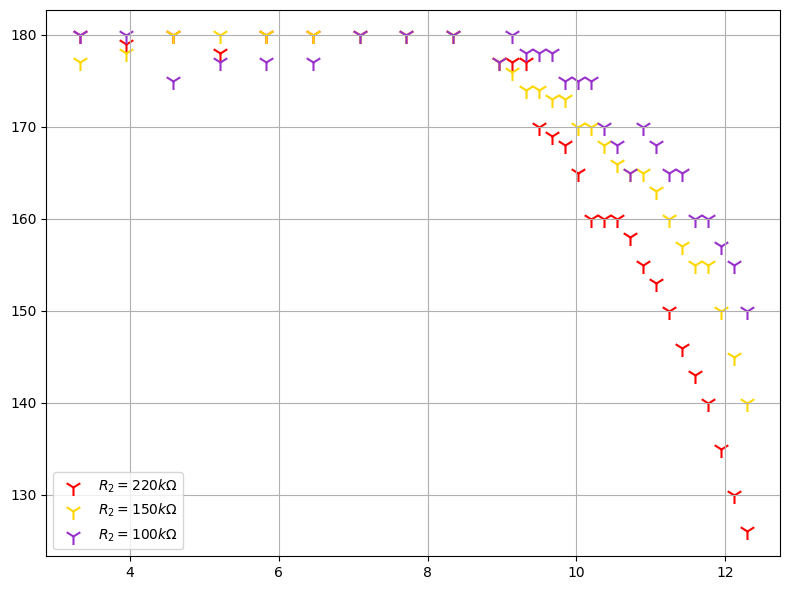

In [78]:
def linear_fit(x, a, b):

    return a * x + b



# Load the data files into dataframes

file_paths = {

    "Invert_220k": "../data/Invert_220k.txt",

    "Invert_150k": "../data/Invert_150k.txt",

    "Invert_100k": "../data/Invert_100k.txt"

}



dataframes = {}

for key, path in file_paths.items():

    # Read the file, split by semicolon, and skip the header

    data = pd.read_csv(path, delimiter=';', skiprows=1, names=['Frequency_Hz', 'Amplified_V', 'Unamplified_mV', 'Phase_Deg'])

    # Remove any extra whitespace from column names and values

    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    dataframes[key] = data

# Liste zum Speichern der Figure-Objekte
figures = []

def colour(key):
    if key == "Invert_220k":
        return "red"
    if key == "Invert_150k":
        return "gold"
    if key == "Invert_100k":
        return "darkorchid"
    
def toplabel(key):
    if key == "Invert_220k":
        return r"$R_2 = 220k\Omega$"
    if key == "Invert_150k":
        return r"$R_2 = 150k\Omega$"
    if key == "Invert_100k":
        return r"$R_2 = 100k\Omega$"

def get_amp(i):
    if i == 0:
        return 220
    if i == 1:
        return 150
    if i == 2:
        return 100


# Prepare plots
plt.figure(figsize=(8, 6))

for i, (key, df) in enumerate(dataframes.items()):

    # Convert data to numpy arrays

    frequencies = df['Frequency_Hz'].astype(float).to_numpy()

    gains = (df['Amplified_V'].astype(float) / ( df['Unamplified_mV'].astype(float) / 1000 )).to_numpy()

    phases = df['Phase_Deg'].astype(float).to_numpy()

    # Log-transform frequency and gain

    log_frequencies = np.log2(frequencies)

   

    axes[i].scatter(log_frequencies, phases, label="Data", color='blue', s=15)
  

    plt.scatter(log_frequencies, phases, marker="1", label=toplabel(key), color=colour(key), s=150)
    # Add labels, title, legend

# Adjust layout and show the plots
plt.tight_layout()

plt.grid(True)
plt.savefig("../figures/inverted_phase")
plt.legend(loc="lower left")
plt.show()  







<h1>Integrator<h1>

Integrator
Zeitkonstante = 0.008903277207914501 $\pm$ -0.0002656732443926156
a = -0.8442767159698955 $\pm$ 0.02847016403847765
b = 4.721335844414083 $\pm$ 0.029839938506738547
 
Differentiator
Zeitkonstante = 0.07985498989339085 $\pm$ -0.010977779204795382
a = 1.0355088514630344 $\pm$ 0.10086328485141974
b = 2.5275429154358804 $\pm$ 0.13747142438376228
 


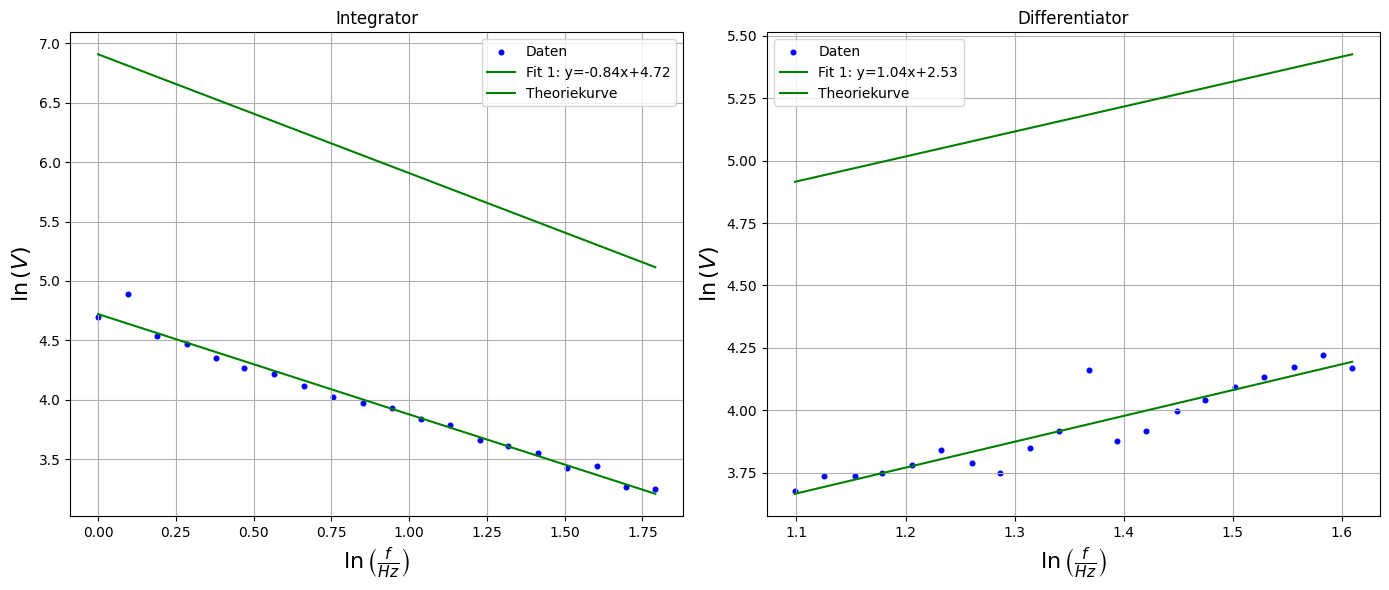

In [169]:
def linear_fit(x, a, b):

    return a * x + b



# Load the data files into dataframes

file_paths = {

    "Integrator": "../data/Integrator.txt",

    "Differentiator": "../data/Differentiator.txt"

}

dataframes = {}

for key, path in file_paths.items():

    # Read the file, split by semicolon, and skip the header

    data = pd.read_csv(path, delimiter=';', skiprows=1, names=['Frequency_Hz', 'Amplified_V', 'Unamplified_mV', 'Phase_Deg'])

    # Remove any extra whitespace from column names and values

    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    dataframes[key] = data

# Liste zum Speichern der Figure-Objekte
figures = []

def toplabel(key):
    if key == "Integrator":
        return "Integrator"
    if key == "Differentiator":
        return "Differentiator"


# Unterscheidung der Theoriekurven
def theoriekurve(data):
    if key == "Integrator":
        return -data -np.log(0.001)
    if key == "Differentiator":
        return data - np.log(0.022)


    return transition_index

def get_amp(i):
    if i == 0:
        return 220
    if i == 1:
        return 150
    if i == 2:
        return 100
    
def intersect_error( popt1, popt2, errors1, errors2 ):
    a1 = popt1[0]
    a2 = popt2[0]
    b1 = popt1[1]
    b2 = popt2[1]

    da1 = errors1[0]
    da2 = errors2[0]
    db1 = errors1[1]
    db2 = errors2[1]

    return np.sqrt(np.exp((b2 - b1) / (a1 - a2)) * ((db1 / (a1 - a2))**2 + (db2 / (a1 - a2))**2 + ((b2 - b1) * da1 / (a1 - a2)**2)**2 + ((b2 - b1) * da2 / (a1 - a2)**2)**2))


def print_mean_error(daten):
    N = len(daten)

    # Mittelwert berechnen
    mittelwert = np.mean(daten)

    # Quadratische Abweichungen vom Mittelwert
    abweichungen = (daten - mittelwert)**2

    # Unsicherheit des Mittelwerts berechnen
    sigma_mittelwert = np.sqrt(np.sum(abweichungen) / (N * (N - 1)))

    # Ausgabe
    print(f"Mittelwert: {mittelwert:.2f}")
    print(f"Unsicherheit des Mittelwerts: {sigma_mittelwert:.3f}")
    
# Prepare plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()

for i, (key, df) in enumerate(dataframes.items()):

    print(toplabel(key))

    # Convert data to numpy arrays

    frequencies = df['Frequency_Hz'].astype(float).to_numpy()

    gains = (df['Amplified_V'].astype(float) / ( df['Unamplified_mV'].astype(float) / 1000 )).to_numpy()

    # Log-transform frequency and gain

    log_frequencies = np.log(frequencies)

    log_gains = np.log(gains)


    # Fit the first region (constant gain)

    popt1, cov_mat1 = curve_fit(linear_fit, log_frequencies, log_gains)

    errors1 = np.sqrt(np.diag(cov_mat1))

    #Berechnen von RC und von dessen Fehler
    prefac = -1
    RC = np.exp(prefac * popt1[1])
    error_RC = prefac * RC * errors1[1]
    
    fit1 = linear_fit(log_frequencies, *popt1)
    print("Zeitkonstante = " + str(RC) + r" $\pm$ " + str(error_RC))

    print("a = " + str(popt1[0]) + r" $\pm$ " + str(errors1[0]))
    print("b = " + str(popt1[1]) + r" $\pm$ " + str(errors1[1]))


    # Plot original data

    axes[i].scatter(log_frequencies, log_gains, label="Daten", color='blue', s=11)

    # Plot the fits
    axes[i].plot(log_frequencies, fit1, label=f"Fit 1: y={popt1[0]:.2f}x+{popt1[1]:.2f}", color='green')
    
    # Plot der Theoriekurven
    axes[i].plot(log_frequencies, theoriekurve(log_frequencies), label=f"Theoriekurve", color='green')


    # Add labels, title, legend

    axes[i].set_title(toplabel(key))

    axes[i].set_xlabel(r"$\ln\left(\frac{f}{Hz}\right)$", fontsize=16)

    axes[i].set_ylabel(r"$\ln\left(V\right)$", fontsize=16)

    axes[i].legend()

    axes[i].grid()
    print(" ")

# Adjust layout and show the plots
plt.tight_layout()

plt.savefig("../figures/Int+Diff")

plt.show()

<h1>Generator<h1>

<h3>Starke Dämpfung<h3>

Peak-Indices: [25 49 69 91]
Peak-Times: [0.00625 0.01225 0.01725 0.02275]
Peak-voltages: [-0.0560402 -0.0640302 -0.0640804 -0.0672965]
 
Peak-Indices: [24 49 69 92]
Peak-Times: [0.006   0.01225 0.01725 0.023  ]
Peak-voltages: [-0.0584523 -0.0616683 -0.0672462 -0.0681005]
 
mean delta t = ( 5.58 \pm 0.19 ) ms


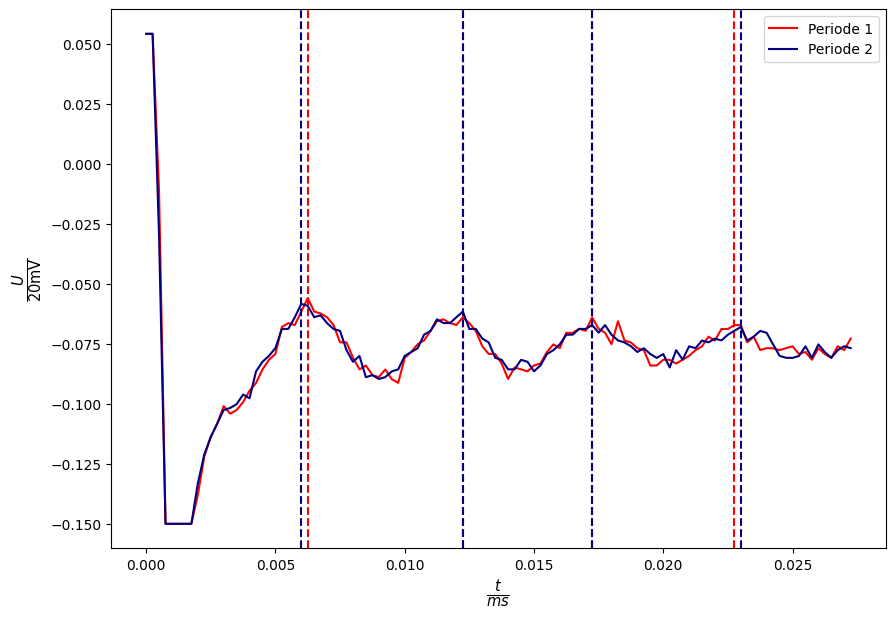

In [246]:
data_generator = pd.read_csv("../data/scope_15.csv", delimiter=',', skiprows=2, names=['Time_ms', 'Unamplified_mV', 'Amplified_V'])

    # Remove any extra whitespace from column names and values

data_generator = data_generator.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

minvalue=0
maxvalue = 110
minmaxarray = np.array([[0,110],[1000,1110]])

def getcolour(i):
    if i==0:
        return plt_colors.to_hex("red")
    if i==1:
        return plt_colors.to_hex("navy")
    if i==2:
        return "#ffffff"
    else:
        return "#ffffff"

# Index für die Farbwahl der Plots
colour_ind = 0

# Mittleres delta t
delta_t_list = []
time_peak_list = []
voltage_peak_list = []

plt.figure(figsize=(10,7))
for minvalue, maxvalue in minmaxarray:
    
    # Eingabe der Daten
    time = data_generator['Time_ms'].astype(float).to_numpy()[minvalue:maxvalue]
    time = time-time[0]
    voltages = data_generator['Amplified_V'].astype(float).to_numpy()[minvalue:maxvalue]

    # Bestimmung der Peaks
    peaks, properties = sc.signal.find_peaks(voltages, height=-0.075, distance=10)

    # Ausgabe der Peak-Indices und -Werte
    peak_indices = peaks
    peak_times = time[peaks]
    peak_voltages = voltages[peaks]

    for n in range(0,len(peak_times)-1):
        delta_t_list.append(peak_times[n+1]-peak_times[n])


    print("Peak-Indices:", peak_indices)
    print("Peak-Times:", peak_times)
    print("Peak-voltages:", peak_voltages)

    # Visualisierung
    colour = getcolour(colour_ind)
    plt.plot(time, voltages, color=colour, label="Periode " + str(colour_ind + 1) )
    # plt.plot(peak_indices, peak_values, color=colour)
    for peak in peak_indices:
        plt.axvline(time[peak], color=colour, linestyle="--")
    
    time_peak_list.append(peak_times.tolist())
    voltage_peak_list.append(peak_voltages.tolist())
    # prepare next iteration
    colour_ind += 1
    print(" ")

delta_t_array = np.array(delta_t_list)
mean_delta_t = round(np.mean(delta_t_array) * 1000, 2)
delta_t_error = round(np.std(delta_t_array)/np.sqrt(len(delta_t_array)) * 1000, 2)
print("mean delta t = ( " + str(mean_delta_t) + r" \pm " + str(delta_t_error) + " ) ms" )

plt.xlabel(r"$\frac{t}{ms}$", fontsize=15)
plt.ylabel(r"$\frac{U}{20 \text{mV}}$", fontsize=15)
plt.legend()

plt.savefig("../figures/generator_dampened.png")
plt.show()
plt.close()





Peak-Indices: [25 49 69 91]
Peak-Times: [0.00625 0.01225 0.01725 0.02275]
Peak-Voltages: [-0.0560402 -0.0640302 -0.0640804 -0.0672965]
log-Peak-Voltages: [-0.0560402 -0.0640302 -0.0640804 -0.0672965]
$\eta$ = -0.6294188268149105 $\pm$ 0.18470928085317756
b = -0.053656574657298874 $\pm$ 0.0029267095642937454
 
Peak-Indices: [24 49 69 92]
Peak-Times: [0.006   0.01225 0.01725 0.023  ]
Peak-Voltages: [-0.0584523 -0.0616683 -0.0672462 -0.0681005]
log-Peak-Voltages: [-0.0584523 -0.0616683 -0.0672462 -0.0681005]
$\eta$ = -0.6128112335753968 $\pm$ 0.11984735822802463
b = -0.054904460708959935 $\pm$ 0.001906877458746663
 


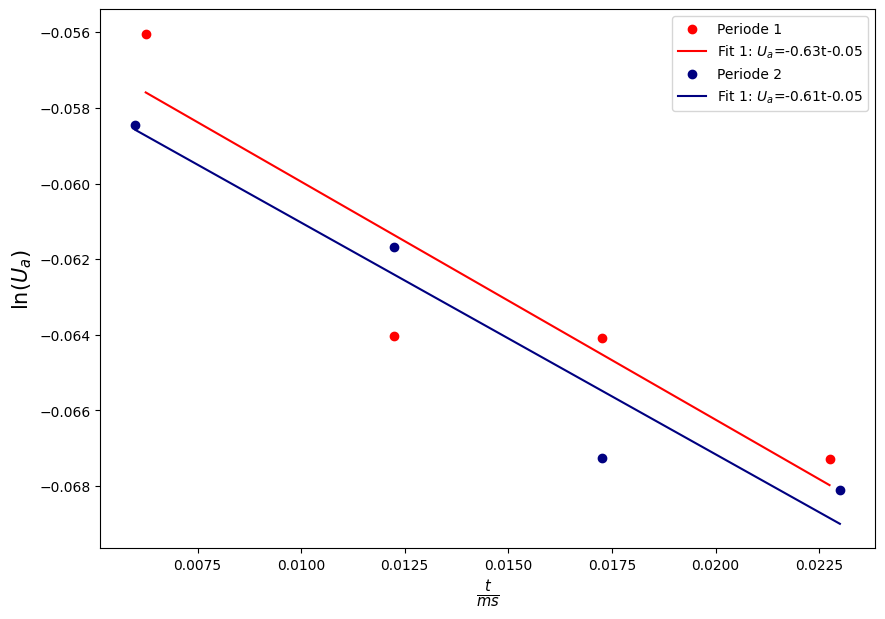

 
eta_mean = 0.6177315483526352 \pm 0.01010796252587984
0.6177315483526352
5.58
Zerfallskonstante $\tau$ = 0.11070457855781993$\pm$0.004182177513755728


In [256]:
def linear_fit(x, a, b):

    return a * x + b


data_generator = pd.read_csv("../data/scope_15.csv", delimiter=',', skiprows=2, names=['Time_ms', 'Unamplified_mV', 'Amplified_V'])

    # Remove any extra whitespace from column names and values

data_generator = data_generator.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

minvalue=0
maxvalue = 110
minmaxarray = np.array([[0,110],[1000,1110]])

def getcolour(i):
    if i==0:
        return plt_colors.to_hex("red")
    if i==1:
        return plt_colors.to_hex("navy")
    if i==2:
        return "#ffffff"
    else:
        return "#ffffff"

# Index für die Farbwahl der Plots
colour_ind = 0

# Mittleres delta t
time_peak_list = []
voltage_peak_list = []
eta_list=[]
eta_error_list = []

plt.figure(figsize=(10,7))
for minvalue, maxvalue in minmaxarray:
    
    # Eingabe der Daten
    time = data_generator['Time_ms'].astype(float).to_numpy()[minvalue:maxvalue]
    time = time-time[0]
    voltages = data_generator['Amplified_V'].astype(float).to_numpy()[minvalue:maxvalue]
    voltages_unamped = data_generator['Unamplified_mV'].astype(float).to_numpy()[minvalue:maxvalue]/1000

    # Bestimmung der Peaks
    peaks, properties = sc.signal.find_peaks(voltages, height=-0.075, distance=10)

    # Ausgabe der Peak-Indices und -Werte
    peak_indices = peaks
    peak_times = time[peaks]
    peak_voltages = voltages[peaks]
    log_peak_voltages = voltages[peaks]


    print("Peak-Indices:", peak_indices)
    print("Peak-Times:", peak_times)
    print("Peak-Voltages:", peak_voltages)
    print("log-Peak-Voltages:", log_peak_voltages)

    # Fitting
    popt1, cov_mat1 = curve_fit(linear_fit, peak_times, log_peak_voltages)
    errors1 = np.sqrt(np.diag(cov_mat1))
    
    fit1 = linear_fit(peak_times, *popt1)
    eta_list.append(popt1[0])
    eta_error_list.append(errors1[0])

    print(r"$\eta$ = " + str(popt1[0]) + r" $\pm$ " + str(errors1[0]))
    print("b = " + str(popt1[1]) + r" $\pm$ " + str(errors1[1]))


    # Visualisierung
    colour = getcolour(colour_ind)


    # Plot original data
    plt.scatter(peak_times, log_peak_voltages, color=colour, label="Periode " + str(colour_ind + 1) )

    # Plot the fits
    plt.plot(peak_times, fit1, label=f"Fit 1: $U_a$={popt1[0]:.2f}t{popt1[1]:.2f}", color=colour)
    # plt.plot(peak_indices, peak_values, color=colour)
    
    time_peak_list.append(peak_times.tolist())
    voltage_peak_list.append(peak_voltages.tolist())
    # prepare next iteration
    colour_ind += 1
    print(" ")


plt.xlabel(r"$\frac{t}{ms}$", fontsize=15)
plt.ylabel(r"$\ln(U_a)$", fontsize=15)
plt.legend()

plt.savefig("../figures/generator_dampened_fit.png")
plt.show()
plt.close()

# Werte für eta und Delta eta in Arrays übertragen
print(" ")
eta_array=np.array(eta_list)
eta_error_array=np.array(eta_error_list)

# Zusammenführen der Ergebnisse beider Fits zur Bestimmung von eta
def combine_mean(mean_array, error_array, key="mean"):
    delta_x = 1 / ((1/error_array)@(1/error_array))
    if key == "mean":
        return mean_array*1/error_array**2 @np.array([1,1]) * delta_x
    if key == "error":
        return delta_x

# Ausgabe von eta mit Fehler
eta_mean = -combine_mean(eta_array, eta_error_array, "mean") # changing sign because of Geradengleichung
eta_error = combine_mean(eta_array, eta_error_array, "error")

print("eta_mean = " + str(eta_mean) + r" \pm " + str(eta_error))

# Berechnung der Zerfallskonstante tau aus eta und delta t
def a_div_b( a, b, error_a, error_b, key="value"):
    z = a/b
    if key == "value":
        return z
    if key == "error":
        return z * np.sqrt((error_a/a)**2 + (error_b/b)**2)
    
print(eta_mean)
print(mean_delta_t)

zerfallskonstante = a_div_b(eta_mean, mean_delta_t, eta_error, delta_t_error)
zerfallskonstante_error = a_div_b(eta_mean, mean_delta_t, eta_error, delta_t_error, "error")
print("Zerfallskonstante $\\tau$ = " + str(zerfallskonstante) + "$\\pm$" + str(zerfallskonstante_error))



<h3>Schwache Dämpfung<h3>

Peak-Indices: [ 25  46  69  92 112 134 157 178 201 222 245 268 289 310 331 354 394 422
 443 463 488]
Peak-Times: [0.00625 0.0115  0.01725 0.023   0.028   0.0335  0.03925 0.0445  0.05025
 0.0555  0.06125 0.067   0.07225 0.0775  0.08275 0.0885  0.0985  0.1055
 0.11075 0.11575 0.122  ]
Peak-Gains: [-0.0508141 -0.0511658 -0.0556382 -0.0544322 -0.0576482 -0.0600603
 -0.0616683 -0.0624221 -0.0616683 -0.0608643 -0.0656382 -0.0640804
 -0.0664925 -0.0672965 -0.0685025 -0.0672965 -0.0689045 -0.0689045
 -0.0684523 -0.0712663 -0.0689045]
 
Peak-Indices: [ 25  47  69  92 112 135 157 180 201 223 246 266 288 311 333 353 378 399
 420 443 464 487]
Peak-Times: [0.00625 0.01175 0.01725 0.023   0.028   0.03375 0.03925 0.045   0.05025
 0.05575 0.0615  0.0665  0.072   0.07775 0.08325 0.08825 0.0945  0.09975
 0.105   0.11075 0.116   0.12175]
Peak-Gains: [-0.0552362 -0.0536281 -0.0556382 -0.0560402 -0.0560402 -0.059608
 -0.059608  -0.0624724 -0.0648342 -0.0628744 -0.0640804 -0.0632764
 -0.0648844 -0.0672965 -

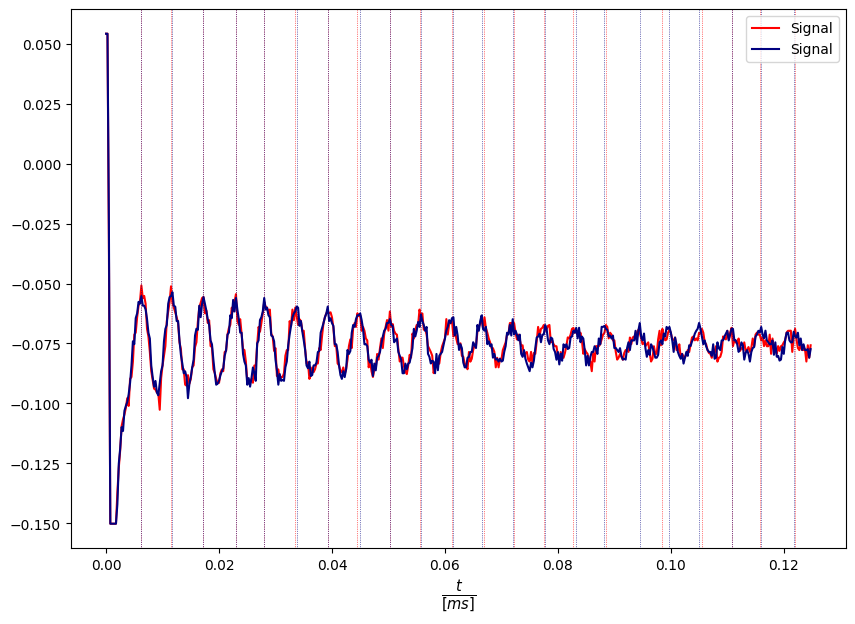

In [161]:
data_generator = pd.read_csv("../data/scope_11.csv", delimiter=',', skiprows=2, names=['Time_ms', 'Unamplified_mV', 'Amplified_V'])

    # Remove any extra whitespace from column names and values

data_generator = data_generator.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

minvalue=0
maxvalue = 500
minmaxarray = np.array([[0,maxvalue],[1000,1000+maxvalue]])

def getcolour(i):
    if i==0:
        return plt_colors.to_hex("red")
    if i==1:
        return plt_colors.to_hex("navy")
    if i==2:
        return "#0000ff"
    else:
        return "#ffffff"

# Index für die Farbwahl der Plots
colour_ind = 0

# Mittleres delta t
delta_t_list = []

plt.figure(figsize=(10,7))
for minvalue, maxvalue in minmaxarray:
    
    # Eingabe der Daten
    time = data_generator['Time_ms'].astype(float).to_numpy()[minvalue:maxvalue]
    time = time-time[0]
    gains = data_generator['Amplified_V'].astype(float).to_numpy()[minvalue:maxvalue]

    # Bestimmung der Peaks
    peaks, properties = sc.signal.find_peaks(gains, height=-0.075, distance=20)

    # Ausgabe der Peak-Indices und -Werte
    peak_indices = peaks
    peak_times = time[peaks]
    peak_gains = gains[peaks]

    for n in range(0,len(peak_times)-1):
        delta_t_list.append(peak_times[n+1]-peak_times[n])


    print("Peak-Indices:", peak_indices)
    print("Peak-Times:", peak_times)
    print("Peak-Gains:", peak_gains)

    # Visualisierung
    colour = getcolour(colour_ind)
    plt.plot(time, gains, color=colour, label="Signal")
    # plt.plot(peak_indices, peak_values, color=colour)
    for peak in peak_indices:
        plt.axvline(time[peak], color=colour, linestyle="dotted", linewidth=0.5)
    
    # prepare next iteration
    colour_ind += 1
    print(" ")

delta_t_array = np.array(delta_t_list)
print("delta_t_array = " + str(delta_t_array))
mean_delta_t = round(np.mean(delta_t_array) * 1000, 2)
delta_t_error = round(np.std(delta_t_array)/np.sqrt(len(delta_t_array)) * 1000, 2)
print("mean delta t = ( " + str(mean_delta_t) + r" \pm " + str(delta_t_error) + " ) ms" )

plt.xlabel(r"$\frac{t}{[ms]}$", fontsize=15)
plt.legend()
plt.show()
plt.close()

full_time = data_generator['Time_ms'].astype(float).to_numpy()
full_gains = data_generator['Amplified_V'].astype(float).to_numpy()


<h1>Diskussion<h1>

In [269]:
# relative Abweichung der Verstärkungen

def relative_abweichung(v_theo, v_exp):
    return (v_theo - v_exp) / v_theo

Leerlaufverstaerkung_theo_arr = np.array(Leerlaufverstaerkung_theo)
Leerlaufverstaerkung_exp_arr = np.array(Leerlaufverstaerkung_exp)[:,0]
Leerlaufverstaerkung_exp_err_arr = np.array(Leerlaufverstaerkung_exp)[:,1]
print(Leerlaufverstaerkung_theo_arr)
print(Leerlaufverstaerkung_exp_arr)
print(relative_abweichung(Leerlaufverstaerkung_theo_arr, Leerlaufverstaerkung_exp_arr))


[220 150 100]
[174.63836693 123.25685289  84.69541678]
[0.20618924 0.17828765 0.15304583]
